# Processing Notebook

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read csv

In [ ]:
nx,ny = 2,2
n = nx * ny

rep = {-1:0}
sizes = [2,5,7]
lens = []
dataframes = {}
for s in sizes:
    df = pd.read_csv(f"neutron5cm_{s}cmSciOver_Ref.csv")
    df['total'] = np.zeros_like(df['vx']).astype(int)
    original_len = len(df['vx'])
    lens.append(original_len)
    for i in range(n):
        col = f'photons{i}'
        df[col] = df[col].replace(rep)
        df['total'] += df[col]
    df['zpred'] = np.ones_like(df['vx']).astype(float) * s/2
    dataframes[f"{s}Sci"] = df

    print(f'{s}cm Sci Perfect Efficiency: {sum(df['total'] > 0)/original_len * 100}%')


## Drop rows with no detections

In [ ]:
for key in dataframes.keys():
    frame: pd.DataFrame = dataframes[key]
    frame = frame[frame['total'] > 0]
    dataframes[key] = frame

## Determine indeces of rows where only ONEDETECTION detector detects and drop rows that are not one detector events and have < 5 photons

In [ ]:
for key in dataframes.keys():
    tmp = np.zeros_like(dataframes[key]['vx']).astype(int)
    original_len = len(tmp)
    for i in range(nx * ny):
        col = f'photons{i}'
        tmp += dataframes[key][col] > 0

    ONEDETECTION = tmp == 1
    dataframes[key]["ONEDETECTION"] = ONEDETECTION

    NOTENOUGH = ~np.logical_and(~ONEDETECTION,dataframes[key]['total'] < 5)
    dataframes[key] = dataframes[key][NOTENOUGH]


## Handle Single Detector Events

In [ ]:
for key in dataframes.keys():
    frame = dataframes[key].copy()
    ONE = frame["ONEDETECTION"]
    frame = frame[ONE]
    frame['xpred'] = np.ones_like(frame['vx'])
    frame['ypred'] = np.ones_like(frame['vx'])
    for i in range(nx * ny):
        xmask = frame[f"photons{i}"] > 0
        xpred = frame.loc[:,'xpred'][xmask] * frame.loc[:,f'xpos{i}'][xmask]
        frame['xpred'][xmask] = xpred

        ymask = frame[f"photons{i}"] > 0
        ypred = frame.loc[:,'ypred'][ymask] * frame.loc[:,f'ypos{i}'][ymask]
        frame['ypred'][ymask] = ypred

    dataframes[key]['xpred'] = np.zeros_like(ONE).astype(float)
    dataframes[key]['ypred'] = np.zeros_like(ONE).astype(float)
    dataframes[key]['xpred'][ONE] = frame['xpred']
    dataframes[key]['ypred'][ONE] = frame['ypred']

## Dynamically determine which columns are right or left and up or down

In [ ]:
left_dropnames = [] # Columns to drop to get left subset
right_dropnames = [] # Columns to drop to get right subset
up_dropnames = [] # Columns to drop to get up subset
down_dropnames = [] # Columns to drop to get down subset
nx = 2
ny = 2
num = 0
for i in range(nx):
    for j in range(ny):
        # if i < (nx / 2):
        #     print("left:",num)
        #     right_dropnames.append(f"photons{num}")
        #     right_dropnames.append(f"ypos{num}")
        #     right_dropnames.append(f"xpos{num}")
        # else:
        if not (i < (nx / 2)):
            print("right:",num)
            left_dropnames.append(f"photons{num}")
            left_dropnames.append(f"ypos{num}")
            left_dropnames.append(f"xpos{num}")

        if j < (ny / 2):
            print("down:",num)
            up_dropnames.append(f"photons{num}")
            up_dropnames.append(f"ypos{num}")
            up_dropnames.append(f"xpos{num}")
        # else:
        #     print('up:',num)
        #     down_dropnames.append(f"photons{num}")
        #     down_dropnames.append(f"ypos{num}")
        #     down_dropnames.append(f"xpos{num}")

        num += 1

## Create R,L,U,D Subsets, Find totals, and Predictions

In [ ]:
for key in dataframes.keys():
    frame = dataframes[key].copy()
    MORETHAN1 = ~frame['ONEDETECTION']
    frame = frame[MORETHAN1]

    left = frame.drop(left_dropnames,axis=1)
    left['total'] = np.zeros_like(left['vx']).astype(int)
    up = frame.drop(up_dropnames,axis=1)
    up['total'] = np.zeros_like(up['vx']).astype(int)

    for i in range(nx * ny):
        # LEFT
        try:
            left['total'] = left['total'] + left[f"photons{i}"]
        except:
            pass
        # UP
        try:
            up['total'] = up['total'] + up[f'photons{i}']
        except:
            pass

    Lratio = left['total'] / frame['total']
    Uratio = up['total'] / frame['total']

    px = np.poly1d(np.polyfit(x=Lratio,y=left['vx'],deg=2))
    xpred = px(Lratio)

    py = np.poly1d(np.polyfit(x=Uratio,y=left['vy'],deg=2))
    ypred = py(Uratio)

    dataframes[key]['xpred'][MORETHAN1] = xpred
    dataframes[key]['ypred'][MORETHAN1] = ypred

## Standard Deviations


In [ ]:
xsds = np.ones(len(dataframes))
ysds = xsds.copy()
zsds = xsds.copy()

for i,key in enumerate(dataframes):
    yhat = dataframes[key]['ypred']
    y = dataframes[key]['vy']

    xhat = dataframes[key]['xpred']
    x = dataframes[key]['vx']

    zhat = dataframes[key]['zpred']
    z = dataframes[key]['vz']

    xsds[i] = np.std(xhat-x)
    ysds[i] = np.std(yhat-y) 
    zsds[i] = np.std(zhat-z)

In [ ]:
fig,ax = plt.subplots(1,1)
sns.scatterplot(x=[2,5,7],y=xsds)
sns.lineplot(x=[2,5,7],y=xsds)
sns.scatterplot(x=[2,5,7],y=ysds,c='orange')
sns.lineplot(x=[2,5,7],y=ysds,c='orange')
sns.scatterplot(x=[2,5,7],y=zsds,c='salmon')
sns.lineplot(x=[2,5,7],y=zsds,c='salmon')
plt.title('Error Standard Deviation (mm) vs Scintillator Thickness')
plt.xlabel('Scintillator Thickness (cm)')
plt.ylabel('Error Standard Deviation (mm)')
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
ax.yaxis.grid(color='white', linestyle='-')
ax.xaxis.grid(color='white', linestyle='-')

## Efficiencies

In [ ]:
for i,key in enumerate(dataframes):
    print(f'Efficiency for {key[0]}cm Scintillator is {len(dataframes[key]['xpred']) / lens[i] * 100}%')

## Wrap It all up into one function

2cm Sci Perfect Efficiency: 75.04857063558146%
5cm Sci Perfect Efficiency: 73.54041916167665%
7cm Sci Perfect Efficiency: 73.22575333443109%
Efficiency for 2cm Scintillator is 71.05190119344991%
Efficiency for 5cm Scintillator is 70.39670658682635%
Efficiency for 7cm Scintillator is 69.85015643010044%


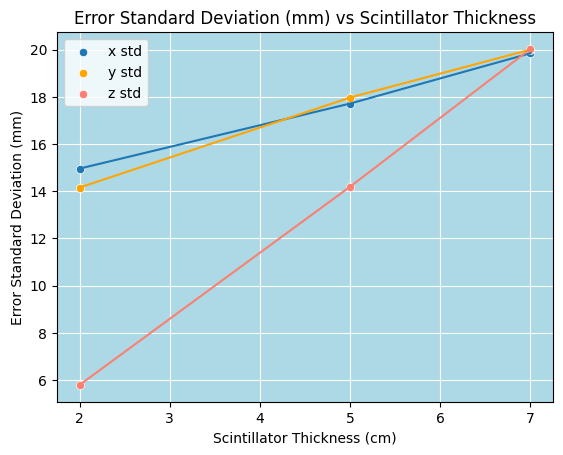

In [4]:
def doItAll():
    nx,ny = 2,2
    n = nx * ny

    rep = {-1:0}
    sizes = [2,5,7]
    lens = []
    dataframes = {}
    for s in sizes:
        df = pd.read_csv(f"neutron5cm_{s}cmSciOver_NoRef.csv")
        df['total'] = np.zeros_like(df['vx']).astype(int)
        original_len = len(df['vx'])
        lens.append(original_len)
        for i in range(n):
            col = f'photons{i}'
            df[col] = df[col].replace(rep)
            df['total'] += df[col]
        df['zpred'] = np.ones_like(df['vx']).astype(float) * s/2
        dataframes[f"{s}Sci"] = df

        print(f'{s}cm Sci Perfect Efficiency: {sum(df['total'] > 0)/original_len * 100}%')

    for key in dataframes.keys():
        frame: pd.DataFrame = dataframes[key]
        frame = frame[frame['total'] > 0]
        dataframes[key] = frame

        del frame

    for key in dataframes.keys():
        tmp = np.zeros_like(dataframes[key]['vx']).astype(int)
        original_len = len(tmp)
        for i in range(nx * ny):
            col = f'photons{i}'
            tmp += dataframes[key][col] > 0

        ONEDETECTION = tmp == 1
        dataframes[key]["ONEDETECTION"] = ONEDETECTION

        NOTENOUGH = ~np.logical_and(~ONEDETECTION,dataframes[key]['total'] < 5)
        dataframes[key] = dataframes[key][NOTENOUGH]

    for key in dataframes.keys():
        frame = dataframes[key].copy()
        ONE = frame["ONEDETECTION"]
        frame = frame[ONE]
        frame['xpred'] = np.ones_like(frame['vx'])
        frame['ypred'] = np.ones_like(frame['vx'])
        for i in range(nx * ny):
            xmask = frame[f"photons{i}"] > 0
            xpred = frame.loc[:,'xpred'][xmask] * frame.loc[:,f'xpos{i}'][xmask]
            frame['xpred'][xmask] = xpred

            ymask = frame[f"photons{i}"] > 0
            ypred = frame.loc[:,'ypred'][ymask] * frame.loc[:,f'ypos{i}'][ymask]
            frame['ypred'][ymask] = ypred

        dataframes[key]['xpred'] = np.zeros_like(ONE).astype(float)
        dataframes[key]['ypred'] = np.zeros_like(ONE).astype(float)
        dataframes[key]['xpred'][ONE] = frame['xpred']
        dataframes[key]['ypred'][ONE] = frame['ypred']

        del frame

    left_dropnames = [] # Columns to drop to get left subset
    up_dropnames = [] # Columns to drop to get up subset
    nx = 2
    ny = 2
    num = 0
    for i in range(nx):
        for j in range(ny):
            if not (i < (nx / 2)):
                left_dropnames.append(f"photons{num}")
                left_dropnames.append(f"ypos{num}")
                left_dropnames.append(f"xpos{num}")

            if j < (ny / 2):
                up_dropnames.append(f"photons{num}")
                up_dropnames.append(f"ypos{num}")
                up_dropnames.append(f"xpos{num}")

            num += 1

    for key in dataframes.keys():
        frame = dataframes[key].copy()
        MORETHAN1 = ~frame['ONEDETECTION']
        frame = frame[MORETHAN1]

        left = frame.drop(left_dropnames,axis=1)
        left['total'] = np.zeros_like(left['vx']).astype(int)
        up = frame.drop(up_dropnames,axis=1)
        up['total'] = np.zeros_like(up['vx']).astype(int)

        for i in range(nx * ny):
            # LEFT
            try:
                left['total'] = left['total'] + left[f"photons{i}"]
            except:
                pass
            # UP
            try:
                up['total'] = up['total'] + up[f'photons{i}']
            except:
                pass

        Lratio = left['total'] / frame['total']
        Uratio = up['total'] / frame['total']

        px = np.poly1d(np.polyfit(x=Lratio,y=left['vx'],deg=2))
        xpred = px(Lratio)

        py = np.poly1d(np.polyfit(x=Uratio,y=left['vy'],deg=2))
        ypred = py(Uratio)

        dataframes[key]['xpred'][MORETHAN1] = xpred
        dataframes[key]['ypred'][MORETHAN1] = ypred

        del frame

    xsds = np.ones(len(dataframes))
    ysds = xsds.copy()
    zsds = xsds.copy()

    for i,key in enumerate(dataframes):
        yhat = dataframes[key]['ypred']
        y = dataframes[key]['vy']

        xhat = dataframes[key]['xpred']
        x = dataframes[key]['vx']

        zhat = dataframes[key]['zpred']
        z = dataframes[key]['vz']

        xsds[i] = np.std(xhat-x)
        ysds[i] = np.std(yhat-y) 
        zsds[i] = np.std(zhat-z)

    for i,key in enumerate(dataframes):
        print(f'Efficiency for {key[0]}cm Scintillator is {len(dataframes[key]['xpred']) / lens[i] * 100}%')

    fig,ax = plt.subplots(1,1)
    sns.scatterplot(x=sizes,y=xsds,label='x std')
    sns.lineplot(x=sizes,y=xsds)
    sns.scatterplot(x=sizes,y=ysds,c='orange',label='y std')
    sns.lineplot(x=sizes,y=ysds,c='orange')
    sns.scatterplot(x=sizes,y=zsds,c='salmon',label='z std')
    sns.lineplot(x=sizes,y=zsds,c='salmon')
    plt.title('Error Standard Deviation (mm) vs Scintillator Thickness')
    plt.xlabel('Scintillator Thickness (cm)')
    plt.ylabel('Error Standard Deviation (mm)')
    ax.set_facecolor('#ADD8E6')
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='white', linestyle='-')
    ax.xaxis.grid(color='white', linestyle='-')
    
doItAll()

In [14]:
n = 4 * 4
rep = {-1:0}
df = pd.read_csv(f"neutron5cm_5cmSci_4x4.csv")
df['total'] = np.zeros_like(df['vx']).astype(int)
original_len = len(df['vx'])
for i in range(n):
    col = f'photons{i}'
    df[col] = df[col].replace(rep)
    df['total'] += df[col]

print(f'5cm Sci Perfect Efficiency: {sum(df['total'] > 0)/original_len * 100}%')
print(sum(df['total']))

5cm Sci Perfect Efficiency: 83.1461948508563%
